In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

# Priprema podataka

In [2]:
#Učitavanje podataka iz excel tablice
X = pd.read_csv('heart_disease_uci.csv')

#dimenzija excel tablice (920 primjera i 16 znacajki)
X.shape

(920, 16)

In [3]:
X.head()
with pd.option_context("display.max_rows", None, 'display.max_columns', None):
    display(X)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
5,6,56,Male,Cleveland,atypical angina,120.0,236.0,False,normal,178.0,False,0.8,upsloping,0.0,normal,0
6,7,62,Female,Cleveland,asymptomatic,140.0,268.0,False,lv hypertrophy,160.0,False,3.6,downsloping,2.0,normal,3
7,8,57,Female,Cleveland,asymptomatic,120.0,354.0,False,normal,163.0,True,0.6,upsloping,0.0,normal,0
8,9,63,Male,Cleveland,asymptomatic,130.0,254.0,False,lv hypertrophy,147.0,False,1.4,flat,1.0,reversable defect,2
9,10,53,Male,Cleveland,asymptomatic,140.0,203.0,True,lv hypertrophy,155.0,True,3.1,downsloping,0.0,reversable defect,1


## Monotoni atributi

In [4]:
# Broj jedinstvenih vrijednosti za svaki atribut
X.nunique()

id          920
age          50
sex           2
dataset       4
cp            4
trestbps     61
chol        217
fbs           2
restecg       3
thalch      119
exang         2
oldpeak      53
slope         3
ca            4
thal          3
num           5
dtype: int64

In [5]:
# "Id" i "dataset" su monotoni atributi s obzirom da imaju 920 jedinstvenih vrijednosti
# Znacajku "id" i "dataset" treba izbaciti jer nam ne daju nikakve korisne informacije
X.drop(('id'), axis=1, inplace=True) 
X.drop(('dataset'), axis=1, inplace=True) 

## Nedostajući podaci

In [6]:
# Broj nedostajucih (NaN) podataka
X.isna().sum()

age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [7]:
X_tmp = X.copy()

In [8]:
# trestbps - krvni tlak u mirovanju
# tip atributa - float (kontinuirani broj)
#-------------------------------------------------------------------------------------------------------------------------------
# Nedostajeća mjerenja krvnog tlaka zamijenit ćemo srednjom vrijednošću jer se radi o realnom broju
# Moguće je izbacivanje nedostajućih podataka jer ih nema puno (6%)
# Izbacivanje te značajke nije opcija jer je značajka previše bitna - dobar indikator zdravlja pacijenta
# Interpolacija nema smisla jer ne estimiramo vrijednosti izmedu postojecih podataka
#-------------------------------------------------------------------------------------------------------------------------------
# ubaci srednju vrijednost krvnog tlaka tamo gdje nedostaje ta informacija

X_tmp.loc[X_tmp.trestbps.isna(),'trestbps'] = X_tmp.loc[:,'trestbps'].mean()

# chol - razina kolesterola u krvi
# tip atributa - float (kontinuirani broj)
#-------------------------------------------------------------------------------------------------------------------------------
# Nedostajeća mjerenja razine kolesterola zamijenit ćemo srednjom vrijednoscu jer se radi o realnom broju
# Moguce je izbacivanje nedostajućih podataka jer ih nema puno (3%)
# Izbacivanje te znacajke nije opcija jer je znacajka previše bitna - dobar indikator zdravlja pacijenta
# Interpolacija nema smisla jer ne estimiramo vrijednosti izmedu postojecih podataka
#-------------------------------------------------------------------------------------------------------------------------------
# ubaci srednju vrijednost razine kolesterola tamo gdje nedostaje ta informacija
X_tmp.loc[X_tmp.chol.isna(),'chol'] = X_tmp.loc[:,'chol'].mean()


# fbs - razina šećera u krvi natašte
# tip atributa - object
#-------------------------------------------------------------------------------------------------------------------------------
# Razinu secera u krvi nataste ne mozemo zamijenit srednjom vrijednoscu jer se ne radi o numerickoj vrijednosti
# Napravit cemo izbacivanje nedostajucih podataka (9.8%)
# Izbacivanje te znacajke nije opcija jer je znacajka bitna 
# Interpolacija nema smisla jer se ne radi o numerickoj vrijednosti
#-------------------------------------------------------------------------------------------------------------------------------
# izbaci zapise s nedostajućom vrijednosti značajke fbs
X_tmp = X_tmp.loc[X_tmp.fbs.notnull(), :]

# restecg - EKG u mirovanju
# tip atributa - object
#-------------------------------------------------------------------------------------------------------------------------------
# EKG nataste ne mozemo zamijeniti srednjom vrijednoscu jer se ne radi o numerickoj vrijednosti
# Napravit cemo izbacivanje nedostajucih podataka (0.2%)
# Izbacivanje te znacajke nije opcija jer je znacajka previse bitna 
# Interpolacija nema smisla jer se ne radi o numerickoj vrijednosti
#-------------------------------------------------------------------------------------------------------------------------------
# izbaci zapise s nedostajućom vrijednosti značajke fbs
X_tmp = X_tmp.loc[X_tmp.restecg.notnull(), :]

# thalch - maksimalni broj otkucaja srca postignut tijekom testa s talijem
# tip atributa - float
#-------------------------------------------------------------------------------------------------------------------------------
# Thalch cemo zamijeniti srednjom vrijednoscu jer se radi o realnoj varijabli
# Mozemo napraviti izbacivanje nedostajucih podataka jer ih nema previse (6%)
# Izbacivanje te znacajke nije opcija jer je znacajka bitna 
# Interpolacija nema smisla jer ne estimiramo vrijednosti izmedu postojecih podataka
#-------------------------------------------------------------------------------------------------------------------------------
# ubaci srednju vrijednost thalcha tamo gdje nedostaje ta informacija
X_tmp.loc[X_tmp.thalch.isna(),'thalch'] = X_tmp.loc[:,'thalch'].mean()

# exang - angina izazvana vjezbanjem
# tip atributa - object
#-------------------------------------------------------------------------------------------------------------------------------
# Anginu izazvana vjezbanjem ne mozemo zamijenit srednjom vrijednoscu jer se ne radi o numerickom tipu podataka
# Napravit cemo izbacivanje nedostajucih podataka jer ih nema previse (6%)
# Izbacivanje te znacajke nije opcija jer je znacajka bitna 
# Interpolacija nema smisla jer se ne radi o numerickom tipu podataka
#-------------------------------------------------------------------------------------------------------------------------------
# izbaci zapise s nedostajucom vrijednosti znacajke exang
X_tmp = X_tmp.loc[X_tmp.exang.notnull(), :]

# oldpeak - pacijentovo stanje depresije
# tip atributa - float
#-------------------------------------------------------------------------------------------------------------------------------
# Pacijentovo stanje depresije zamijeniti cemo srednjom vrijednoscu jer se radi o realnom tipu podataka
# Mozemo napraviti izbacivanje nedostajucih podataka jer ih nema previse (6.7%)
# Izbacivanje te znacajke nije opcija jer je znacajka bitna 
# Interpolacija nema smisla jer ne estimiramo vrijednosti izmedu postojecih podataka
#-------------------------------------------------------------------------------------------------------------------------------
# ubaci srednju vrijednost tamo gdje nedostaje ta informacija
X_tmp.loc[X_tmp.oldpeak.isna(),'oldpeak'] = X_tmp.loc[:,'oldpeak'].mean()

# slope - stanje pacijenta tijekom najveceg tjelesnog opterecenja
# tip atributa - object
#-------------------------------------------------------------------------------------------------------------------------------
# slope ne mozemo zamijeniti srednjom vrijednoscu jer se ne radi o numerickom tipu podataka
# Ne mozemo napraviti izbacivanje nedostajucih podataka jer ih ima previse (33%)
# Izbacit cemo ovu znacajku 
# Interpolacija nema smisla jer se ne radi o numerickom tipu podataka
#-------------------------------------------------------------------------------------------------------------------------------
# izbaci stupac slope
X_tmp.drop(['slope'], axis=1, inplace=True)

# ca - rezultat fluoroskopije
# tip atributa - float
#-------------------------------------------------------------------------------------------------------------------------------
# Rezultat fluoroskopije ne mozemo zamijeniti srednjom vrijednoscu jer imamo previse nedostajucih podataka
# Ne mozemo napraviti izbacivanje nedostajucih podataka jer ih ima previse (66%)
# Izbacit cemo ovu znacajku 
# Interpolacija nema nikakvog smisla ovdje
#-------------------------------------------------------------------------------------------------------------------------------
# izbaci stupac ca
X_tmp.drop(['ca'], axis=1, inplace=True)

# thal - rezultat talijum testa
# tip atributa - object
#-------------------------------------------------------------------------------------------------------------------------------
# Rezultat fluoroskopije ne mozemo zamijeniti srednjom vrijednoscu jer se ne radi o numerickom tipu podataka
# Ne mozemo napraviti izbacivanje nedostajucih podataka jer ih ima previse (53%)
# Izbacit cemo ovu znacajku 
# Interpolacija nema smisla jer se ne radi o numerickom tipu podataka
#-------------------------------------------------------------------------------------------------------------------------------
# izbaci stupac thal
X_tmp.drop(['thal'], axis=1, inplace=True)

## Stršeće vrijednosti (outlieri)

#### Izbacivanje strsecih vrijednosti:
    whis_l - donja granica whiskera
    whis_h - gornja granica whiskera
    interkvartil := 3. kvartil - 1. kvartil
#### Formula za izracunavanje whiskersa (granica nakon kojih se pojavljuju strsece vrijednosti odnosno "outlieri"):
    whis_l = 1. kvartil - 1.5 * interkvartil
    whis_h = 3. kvartil + 1.5 * interkvartil

In [9]:
X_tmp.describe()

,age,trestbps,chol,thalch,oldpeak,num
count,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000
mean,53.071059,132.783459,218.468371,138.677003,0.887403,0.919897
std,9.430970,18.576960,92.664496,25.808812,1.081533,1.133424
min,28.000000,0.000000,0.000000,60.000000,-1.000000,0.000000
25%,46.000000,120.000000,198.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,228.000000,140.000000,0.500000,1.000000
75%,60.000000,140.000000,269.000000,159.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,202.000000,6.200000,4.000000


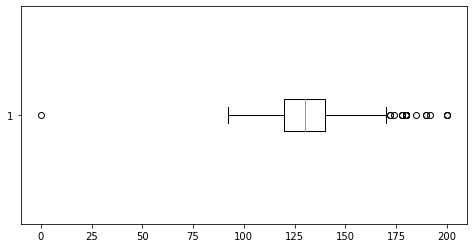

In [10]:
plt.figure(figsize=(8, 4)) 
plt.boxplot(X_tmp.trestbps, vert=False)
plt.show()

In [11]:
# whis_l = 120 - 1.5*20 = 90
# whis_h = 140 + 1.5*20 = 170
# trestbps outliers < 90 i > 170
print('Trestbps < 90: ', (X_tmp.trestbps < 90).sum())
print('Trestbps > 170: ', (X_tmp.trestbps > 170).sum())

Trestbps < 90:  1
Trestbps > 170:  24


In [12]:
X_tmp.loc[X_tmp.trestbps < 90, 'trestbps']

753    0.0
Name: trestbps, dtype: float64

In [13]:
X_tmp.loc[X_tmp.trestbps > 170, 'trestbps']

14     172.0
83     180.0
126    200.0
172    174.0
183    178.0
188    192.0
201    180.0
213    178.0
231    180.0
338    190.0
375    180.0
387    180.0
475    180.0
484    180.0
548    200.0
569    180.0
595    180.0
700    185.0
701    200.0
727    180.0
779    178.0
854    172.0
889    180.0
896    190.0
Name: trestbps, dtype: float64

In [14]:
# Izbacivanje tih vrijednosti:
X_tmp = X_tmp[~X_tmp['trestbps'].isin(X_tmp.loc[X_tmp.trestbps < 90, 'trestbps'])]
X_tmp = X_tmp[~X_tmp['trestbps'].isin(X_tmp.loc[X_tmp.trestbps > 170, 'trestbps'])]

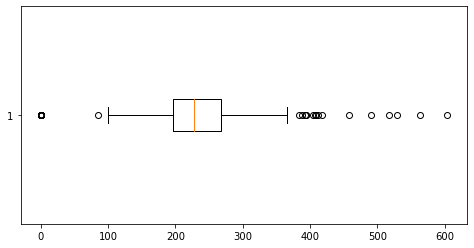

In [15]:
plt.figure(figsize=(8, 4)) 
plt.boxplot(X_tmp.chol, vert=False)
plt.show()

In [16]:
# whis_l = 198 - 1.5*71 = 91.5 --> donja granica je postavljena na whis_l = 126 prema tablici 2 iz casopisa
# whis_h = 269 + 1.5*71 = 375.5
# chol outliers < 91.5 i > 375.5
print('Chol < 126: ', (X_tmp.chol < 126).sum())
print('Chol > 375.5: ', (X_tmp.chol > 375.5).sum())

Chol < 126:  81
Chol > 375.5:  16


In [17]:
X_tmp.loc[X_tmp.chol < 126, 'chol']

431    100.0
473     85.0
499    117.0
602      0.0
604      0.0
       ...  
787      0.0
796      0.0
812      0.0
818      0.0
819      0.0
Name: chol, Length: 81, dtype: float64

In [18]:
X_tmp.loc[X_tmp.chol > 375.5, 'chol']

48     417.0
121    407.0
152    564.0
173    394.0
181    409.0
373    412.0
461    394.0
528    529.0
531    392.0
546    603.0
566    404.0
568    518.0
576    388.0
584    491.0
800    458.0
802    384.0
Name: chol, dtype: float64

In [19]:
# Izbacivanje tih vrijednosti:
X_tmp = X_tmp[~X_tmp['chol'].isin(X_tmp.loc[X_tmp.chol < 126, 'chol'])]
X_tmp = X_tmp[~X_tmp['chol'].isin(X_tmp.loc[X_tmp.chol > 375.5, 'chol'])]

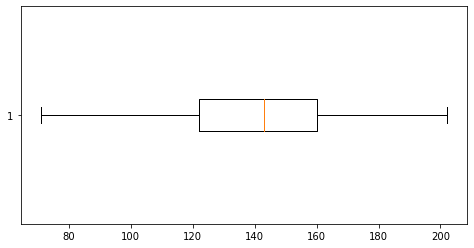

In [20]:
plt.figure(figsize=(8, 4)) 
plt.boxplot(X_tmp.thalch, vert=False)
plt.show()

In [21]:
# whis_l = 120 - 1.5*39 = 61.5 --> donja granica je postavljena na whis_l = 71 prema tablici 2 iz casopisa
# whis_h = 159 + 1.5*39 = 217.5
# thalch outliers < 61.5 i > 217.5
print('Thalch < 61.5: ', (X_tmp.thalch < 71).sum())
print('Thalch > 217.5: ', (X_tmp.thalch > 217.5).sum())

Thalch < 61.5:  0
Thalch > 217.5:  0


In [22]:
X_tmp.loc[X_tmp.thalch < 71, 'thalch']

Series([], Name: thalch, dtype: float64)

In [23]:
# Izbacivanje te vrijednosti:
X_tmp = X_tmp[~X_tmp['thalch'].isin(X_tmp.loc[X_tmp.thalch < 71, 'thalch'])]

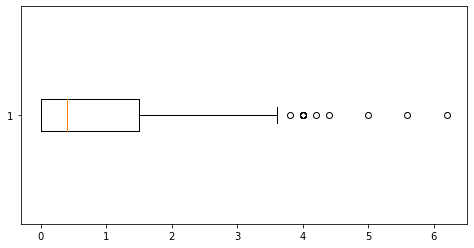

In [24]:
plt.figure(figsize=(8, 4)) 
plt.boxplot(X_tmp.oldpeak, vert=False)
plt.show()

In [25]:
# whis_l = 0 - 1.5*1.5 = -2.25 --> donja granica je postavljena na whis_l = 0 prema tablici 2 iz casopisa 
# whis_h = 1.5 + 1.5*1.5 = 3.75
# chol outliers < 91.5 i > 375.5
print('Oldpeak < 0: ', (X_tmp.oldpeak < 0).sum())
print('Oldpeak > 3.75: ', (X_tmp.oldpeak > 3.75).sum())

Oldpeak < 0:  0
Oldpeak > 3.75:  12


In [26]:
X_tmp.loc[X_tmp.oldpeak < 0, 'oldpeak']

Series([], Name: oldpeak, dtype: float64)

In [27]:
X_tmp.loc[X_tmp.oldpeak > 3.75, 'oldpeak']

91     6.2
123    5.6
191    4.2
211    3.8
285    4.4
293    4.0
567    4.0
589    5.0
804    4.0
825    4.0
841    4.0
863    4.0
Name: oldpeak, dtype: float64

In [28]:
# Izbacivanje tih vrijednosti:
X_tmp = X_tmp[~X_tmp['oldpeak'].isin(X_tmp.loc[X_tmp.oldpeak < 0, 'oldpeak'])]
X_tmp = X_tmp[~X_tmp['oldpeak'].isin(X_tmp.loc[X_tmp.oldpeak > 3.75, 'oldpeak'])]

In [29]:
X_tmp.reset_index(inplace=True)
with pd.option_context("display.max_rows", None, 'display.max_columns', None):
    display(X_tmp)

,index,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,num
0,0,63,Male,typical angina,145.000000,233.000000,True,lv hypertrophy,150.0,False,2.300000,0
1,1,67,Male,asymptomatic,160.000000,286.000000,False,lv hypertrophy,108.0,True,1.500000,2
2,2,67,Male,asymptomatic,120.000000,229.000000,False,lv hypertrophy,129.0,True,2.600000,1
3,3,37,Male,non-anginal,130.000000,250.000000,False,normal,187.0,False,3.500000,0
4,4,41,Female,atypical angina,130.000000,204.000000,False,lv hypertrophy,172.0,False,1.400000,0
5,5,56,Male,atypical angina,120.000000,236.000000,False,normal,178.0,False,0.800000,0
6,6,62,Female,asymptomatic,140.000000,268.000000,False,lv hypertrophy,160.0,False,3.600000,3
7,7,57,Female,asymptomatic,120.000000,354.000000,False,normal,163.0,True,0.600000,0
8,8,63,Male,asymptomatic,130.000000,254.000000,False,lv hypertrophy,147.0,False,1.400000,2
9,9,53,Male,asymptomatic,140.000000,203.000000,True,lv hypertrophy,155.0,True,3.100000,1


In [30]:
X_tmp.describe()

,index,age,trestbps,chol,thalch,oldpeak,num
count,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000
mean,372.723437,52.339062,131.056457,239.288107,141.623437,0.815097,0.754687
std,250.858526,9.515281,15.780985,45.738270,24.959443,0.975311,1.037999
min,0.000000,28.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,167.750000,45.000000,120.000000,204.000000,122.750000,0.000000,0.000000
50%,341.500000,53.000000,130.000000,234.000000,143.000000,0.400000,0.000000
75%,518.250000,59.000000,140.000000,269.250000,160.250000,1.500000,1.000000
max,919.000000,77.000000,170.000000,365.000000,202.000000,3.600000,4.000000


## Transformacija atributa u numeričke vrijednosti

In [31]:
# Sve atribute treba transfomirati u numericke vrijednosti kako bi mogli iskoristiti te podatke
X_tmp.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     640 non-null    int64  
 1   age       640 non-null    int64  
 2   sex       640 non-null    object 
 3   cp        640 non-null    object 
 4   trestbps  640 non-null    float64
 5   chol      640 non-null    float64
 6   fbs       640 non-null    object 
 7   restecg   640 non-null    object 
 8   thalch    640 non-null    float64
 9   exang     640 non-null    object 
 10  oldpeak   640 non-null    float64
 11  num       640 non-null    int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 60.1+ KB


In [32]:
X_tmp['sex'].unique()

array(['Male', 'Female'], dtype=object)

In [33]:
# Moramo promijeniti format znacajke "sex" u numericku vrijednost kako bi mogli te podatke koristiti za predikciju
le = LabelEncoder()
le.fit(X_tmp.loc[:,'sex'])

X_tmp.loc[:,'sex'] = le.transform(X_tmp.loc[:,'sex'])

In [34]:
X_tmp['fbs'].unique()

array([True, False], dtype=object)

In [35]:
# Moramo promijeniti format znacajke "fbs" u numericku vrijednost kako bi mogli te podatke koristiti za predikciju
le.fit(X_tmp.loc[:,'fbs'])
X_tmp.loc[:,'fbs'] = le.transform(X_tmp.loc[:,'fbs'])

In [36]:
X_tmp['exang'].unique()

array([False, True], dtype=object)

In [37]:
le.fit(X_tmp.loc[:,'exang'])
X_tmp.loc[:,'exang'] = le.transform(X_tmp.loc[:,'exang'])

In [38]:
X_tmp['cp'].unique()

array(['typical angina', 'asymptomatic', 'non-anginal', 'atypical angina'],
      dtype=object)

In [39]:
# Moramo promijeniti format znacajke "cp" u numericku vrijednost kako bi mogli te podatke koristiti za predikciju
replacement_dict = {}
i = 0
for value in X_tmp['cp']:    
    if 'asymptomatic' == value:
        replacement_dict[value] = 0 
    if 'atypical angina' == value:
        replacement_dict[value] = 1
    if 'non-anginal' == value:
        replacement_dict[value] = 2
    if 'typical angina' == value:
        replacement_dict[value] = 3
    i = i+1   

X_tmp['cp'] = X_tmp['cp'].replace(replacement_dict)

In [40]:
X_tmp['restecg'].unique()

array(['lv hypertrophy', 'normal', 'st-t abnormality'], dtype=object)

In [41]:
# Moramo promijeniti format znacajke "restecg" u numericku vrijednost kako bi mogli te podatke koristiti za predikciju 
replacement_dict = {}
i = 0
for value in X_tmp['restecg']:    
    if  'lv hypertrophy' == value:
        replacement_dict[value] = 0 
    if  'normal' == value:
        replacement_dict[value] = 1
    if 'st-t abnormality' == value:
        replacement_dict[value] = 2
    i = i+1   

X_tmp['restecg'] = X_tmp['restecg'].replace(replacement_dict)

In [42]:
# Vrijednosti Target atributa smiju bit samo 0 ili 1. Zato cemo vrijednosti vece od 1 postaviti na vrijednost 1
X_tmp['num'].unique()

array([0, 2, 1, 3, 4], dtype=int64)

In [43]:
replacement_dict = {}
i = 0
for value in X_tmp['num']:    
    if value >= 1:
        replacement_dict[value] = 1
    if value < 1:
        replacement_dict[value] = 0
        
X_tmp['num'] = X_tmp['num'].replace(replacement_dict)

In [44]:
X_tmp.reset_index(inplace=True)

# Maknut level_0 i index atribute koji se stvorio kada sam resetirao indexiranje vrijednosti zasebnih znacajki
X_tmp.drop(('level_0'), axis=1, inplace=True)
X_tmp.drop(('index'), axis=1, inplace=True)

with pd.option_context("display.max_rows", None, 'display.max_columns', None):
    display(X_tmp)

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,num
0,63,1,3,145.000000,233.000000,1,0,150.0,0,2.300000,0
1,67,1,0,160.000000,286.000000,0,0,108.0,1,1.500000,1
2,67,1,0,120.000000,229.000000,0,0,129.0,1,2.600000,1
3,37,1,2,130.000000,250.000000,0,1,187.0,0,3.500000,0
4,41,0,1,130.000000,204.000000,0,0,172.0,0,1.400000,0
5,56,1,1,120.000000,236.000000,0,1,178.0,0,0.800000,0
6,62,0,0,140.000000,268.000000,0,0,160.0,0,3.600000,1
7,57,0,0,120.000000,354.000000,0,1,163.0,1,0.600000,0
8,63,1,0,130.000000,254.000000,0,0,147.0,0,1.400000,1
9,53,1,0,140.000000,203.000000,1,0,155.0,1,3.100000,1


### Korelacijska matrica

In [45]:
X_tmp.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,num
age,1.000000,0.041171,-0.097706,0.246550,0.097438,0.220066,-0.090026,-0.389268,0.224667,0.285094,0.303814
sex,0.041171,1.000000,-0.150712,0.070225,-0.055836,0.074645,-0.001332,-0.133139,0.192946,0.151354,0.304394
cp,-0.097706,-0.150712,1.000000,-0.017213,-0.091748,0.030568,-0.053095,0.318032,-0.410963,-0.212095,-0.408843
trestbps,0.246550,0.070225,-0.017213,1.000000,0.043923,0.167995,0.014884,-0.109786,0.143652,0.191503,0.164830
chol,0.097438,-0.055836,-0.091748,0.043923,1.000000,0.035837,-0.098280,-0.021320,0.131295,0.057370,0.110876
fbs,0.220066,0.074645,0.030568,0.167995,0.035837,1.000000,-0.012104,-0.086137,0.048592,0.053404,0.129375
restecg,-0.090026,-0.001332,-0.053095,0.014884,-0.098280,-0.012104,1.000000,-0.121676,0.046486,-0.062986,-0.023207
thalch,-0.389268,-0.133139,0.318032,-0.109786,-0.021320,-0.086137,-0.121676,1.000000,-0.403350,-0.264660,-0.382234
exang,0.224667,0.192946,-0.410963,0.143652,0.131295,0.048592,0.046486,-0.403350,1.000000,0.458153,0.511681
oldpeak,0.285094,0.151354,-0.212095,0.191503,0.057370,0.053404,-0.062986,-0.264660,0.458153,1.000000,0.475611


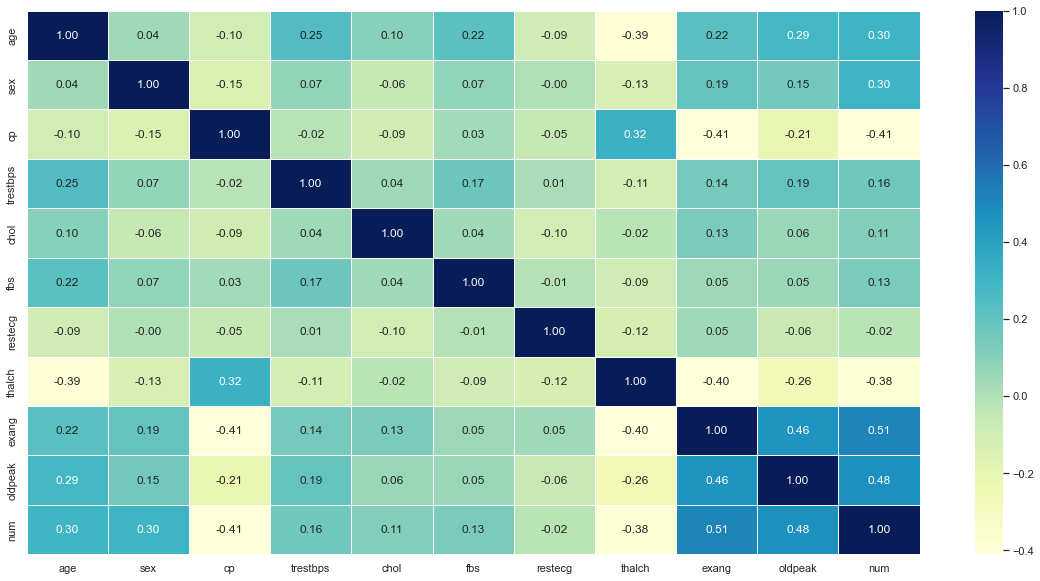

In [46]:
sns.set(rc={'figure.figsize':(20,10)})
sns.heatmap(X_tmp.corr(), annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.show()

Vidimo da nema korelacije između para značajki jer im koeficijent nije veći ili jednak od 0.9. Ne moramo odbaciti niti jednu značajku jer nisu redundantne.

## Klasifikacija pročišćenih podataka samo za primjer 

In [47]:
def klasificiraj(df):
    # odvajanje oznake klase
    X = df.loc[:, df.columns != 'num']
    y = df.loc[:, 'num']
    
    ######## Ovako izgleda treniranje modela na pojedinačnoj podijeli podataka ########
    
    # razdvoji podatke
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # instanciraj i treniraj model 
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    ######## Preporučeni način validiranja modela je korištenjem unakrsne provjere ########
    # unakrsna valicadija
    scores = cross_val_score(model, X, y, cv=20)
    
    
    # evaluiraj model
    print('Točnost: ', scores.mean(), ' +- ', scores.std())
   
# pozovi definiranu funkciju
klasificiraj(X_tmp)

Točnost:  0.79375  +-  0.07288689868556625


# Vizualizacija podataka

### Dob pacijenata u ovisnosti o spolu

In [48]:
X_tmp_sex = X_tmp.groupby('sex').describe().transpose()
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)
display(X_tmp_sex)

sex                      0           1
age      count  162.000000  478.000000
         mean    51.666667   52.566946
         std      9.373545    9.561821
         min     30.000000   28.000000
         25%     45.000000   46.000000
         50%     51.000000   54.000000
         75%     58.000000   59.000000
         max     76.000000   77.000000
cp       count  162.000000  478.000000
         mean     1.098765    0.769874
         std      0.913732    0.948005
         min      0.000000    0.000000
         25%      0.000000    0.000000
         50%      1.000000    0.000000
         75%      2.000000    2.000000
         max      3.000000    3.000000
trestbps count  162.000000  478.000000
         mean   129.154321  131.701114
         std     15.619136   15.799737
         min     94.000000   94.000000
         25%    120.000000  120.000000
         50%    130.000000  130.000000
         75%    140.000000  140.000000
         max    170.000000  170.000000
chol     count  162.000000  478.000000
         mean   243.671494  237.802525
         std     48.284498   44.797690
         min    141.000000  126.000000
         25%    204.000000  204.000000
         50%    239.500000  232.500000
         75%    275.750000  267.000000
         max    360.000000  365.000000
fbs      count  162.000000  478.000000
         mean     0.098765    0.158996
         std      0.299272    0.366055
         min      0.000000    0.000000
         25%      0.000000    0.000000
         50%      0.000000    0.000000
         75%      0.000000    0.000000
         max      1.000000    1.000000
restecg  count  162.000000  478.000000
         mean     0.888889    0.887029
         std      0.600207    0.610700
         min      0.000000    0.000000
         25%      1.000000    1.000000
         50%      1.000000    1.000000
         75%      1.000000    1.000000
         max      2.000000    2.000000
thalch   count  162.000000  478.000000
         mean   147.327160  139.690377
         std     22.459026   25.485400
         min     90.000000   71.000000
         25%    130.250000  120.000000
         50%    150.000000  140.000000
         75%    163.000000  160.000000
         max    192.000000  202.000000
exang    count  162.000000  478.000000
         mean     0.197531    0.410042
         std      0.399371    0.492356
         min      0.000000    0.000000
         25%      0.000000    0.000000
         50%      0.000000    0.000000
         75%      0.000000    1.000000
         max      1.000000    1.000000
oldpeak  count  162.000000  478.000000
         mean     0.561728    0.900967
         std      0.767923    1.022770
         min      0.000000    0.000000
         25%      0.000000    0.000000
         50%      0.000000    0.500000
         75%      1.000000    1.600000
         max      3.600000    3.600000
num      count  162.000000  478.000000
         mean     0.191358    0.539749
         std      0.394590    0.498940
         min      0.000000    0.000000
         25%      0.000000    0.000000
         50%      0.000000    1.000000
         75%      0.000000    1.000000
         max      1.000000    1.000000

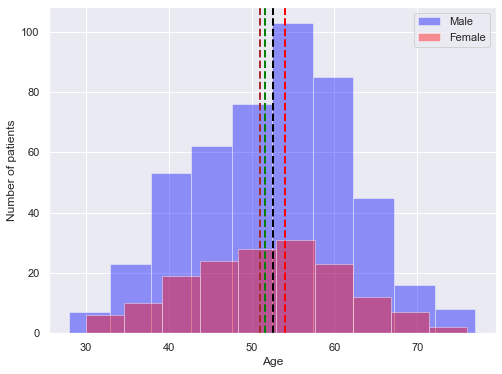

In [49]:
male_age = X_tmp.groupby('sex').age.get_group(1)
female_age = X_tmp.groupby('sex').age.get_group(0)

plt.figure(figsize=(8, 6)) 
plt.hist(male_age, bins=10, color='blue', alpha=0.4, label='Male')
plt.hist(female_age, bins=10, color='red', alpha=0.4, label='Female')
plt.legend(loc='best')
plt.xlabel('Age')
plt.ylabel('Number of patients')

plt.axvline(male_age.mean(), color='black', linestyle='dashed', linewidth=2)
plt.axvline(male_age.median(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(female_age.mean(), color='green', linestyle='dashed', linewidth=2)
plt.axvline(female_age.median(), color='brown', linestyle='dashed', linewidth=2)

plt.show()

Iz grafa možemo zaključiti nekoliko stvari:
- pacijenti su pretežito muškog spola
- prosječna dob oba spola je 50-ak godina
- pacijenti muškog spola su u prosjeku par godina stariji od ženskog spola

### Udio pacijenata s mogućnosti otkazivanja srca za svaki spol

In [50]:
hf = pd.crosstab(X_tmp['num'], X_tmp['sex'])
hf # hf - heart failure

sex,0,1
num,,
0,131,220
1,31,258


([<matplotlib.patches.Wedge at 0x234ababdcd0>,
 [Text(-1.0983314082468263, 0.060564987067972656, 'No chance for female hf'),
  Text(-0.8122199350686703, -0.7418212568247456, 'High chance for female hf'),
  Text(0.42980426977888236, -1.012555326725331, 'No chance for male hf'),
  Text(0.4220601103014289, 1.0158076901128215, 'High chance for male hf')],
 [Text(-0.5990898590437234, 0.03303544749162145, '20.5%'),
  Text(-0.44302905549200194, -0.4046297764498612, '4.8%'),
  Text(0.23443869260666308, -0.5523029054865441, '34.4%'),
  Text(0.23021460561896118, 0.5540769218797207, '40.3%')])

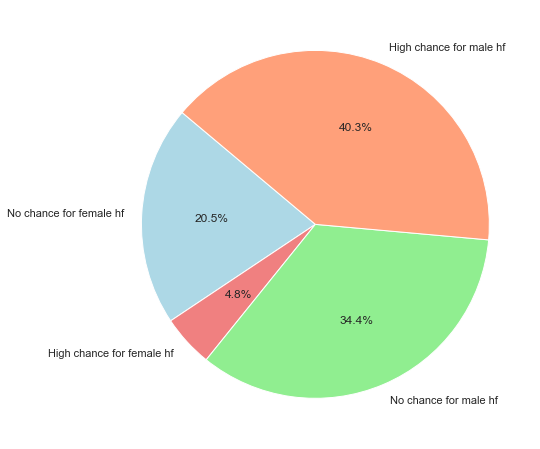

In [51]:
# Tortni grafikon
labels = ['No chance for female hf', 'High chance for female hf', 'No chance for male hf', 'High chance for male hf']
sizes = [hf[0][0], hf[0][1], hf[1][0], hf[1][1]]
colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightsalmon']

plt.figure(figsize=(8, 8))  # Set the figure size

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

Iz tortnog grafikona možemo zaključiti da muškarci imaju puno veću šansu zatajenja srca od žena. 

### Dijagram raspršenosti (heartbeat / age / num)

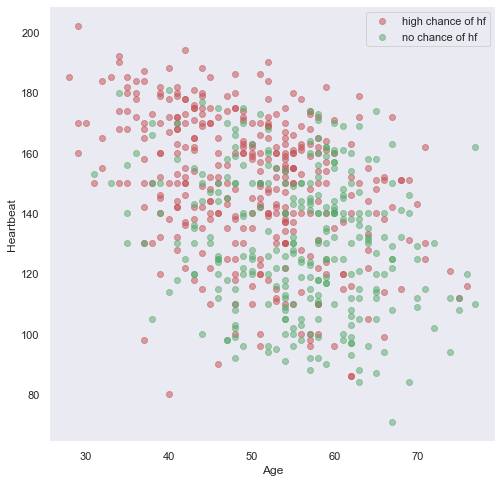

In [52]:

mask_hf = X_tmp.num == 1

# plot
plt.figure(figsize=(8, 8))
plt.scatter(X_tmp.loc[~mask_hf,'age'], X_tmp.loc[~mask_hf,'thalch'], alpha=0.5, c='r', label='high chance of hf')
plt.scatter(X_tmp.loc[mask_hf,'age'], X_tmp.loc[mask_hf,'thalch'], alpha=0.5, c='g', label='no chance of hf')
plt.xlabel('Age')
plt.ylabel('Heartbeat')
plt.legend(loc='best')
plt.grid()
plt.show()

Iz dijagrama raspršenosti možemo zaključit sljedeće:
1. Puno više ljudi umire ako osobe imaju veći broj otkucaja srca
2. Još veće su šanse od zatajenja srca ako je osoba starija i ima veći broj otkucaja srca
3. Najveći broj ljudi koji umiru od zatajenja srca su osobe između 35 i 60 godina

### Posloženi dijagram 

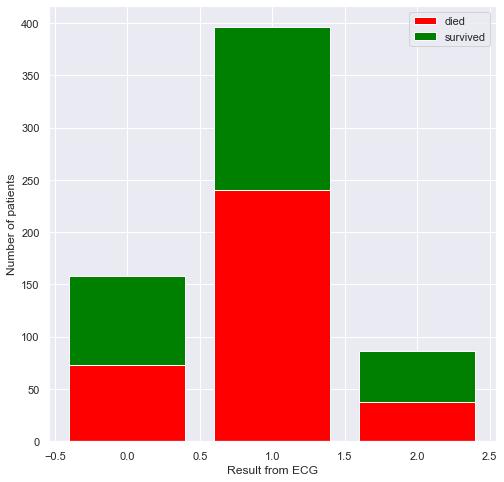

In [53]:
# mask
mask_survived = X_tmp.num == 1

count_per_restecg_died = X_tmp.loc[~mask_survived,:].groupby('restecg').count().loc[:,'age'].values
count_per_restecg_survived = X_tmp.loc[mask_survived,:].groupby('restecg').count().loc[:,'age'].values
restecg_values = X_tmp.groupby('restecg').count().index.values

# plot
plt.figure(figsize=(8, 8))
plt.bar(restecg_values, count_per_restecg_died, color='red', label='died')
plt.bar(restecg_values, count_per_restecg_survived, color='green', label='survived', bottom=count_per_restecg_died)
plt.legend(loc='best')
plt.xlabel('Result from ECG')
plt.ylabel('Number of patients')
plt.show()

Rezultati s ECG-a predstavljaju nivo boli:
   - lv hypertrophy = 0 
   - normal = 1
   - st-t abnormality = 2
   
Dijagram nam ne daje baš previše informacija jer ispada da je veća vjerojatnost da neko umre s normalnim rezultatom ECG-a nego s abnormalnim. Možemo vidjeti s dijagrama da najveći broj prijavljenih pacijenata ima normalan ECG.